In [307]:
import spacy
from gensim.parsing.preprocessing import strip_tags

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import joblib
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large'}

pylab.rcParams.update(params)

import warnings
warnings.filterwarnings("ignore")

import tqdm

# Utils

In [306]:
class SpacyTokenizer():
    '''
    Custom tokenizer
    '''
    def __init__(self, lang='en'):
        self.lang = lang
        self.nlp = spacy.load(lang)
        self.spacy_tokenizer = self.nlp.Defaults.create_tokenizer(self.nlp)
        self.stop_words = self.nlp.Defaults.stop_words
        
    def tokenizer(self, input_text: str):
        '''
        Preprocess and split text into tokens.
        
        Parameters:
        
        input_text: str
            Input text.
            
        Returns:
            np.ndarray: list of tokens
        '''
        text = strip_tags(input_text.lower())
        text = re.sub(r"[^A-Za-z]", " ", text)

        spacy_tokens = self.spacy_tokenizer(text)
        tokens = [token.lemma_.strip() for token in spacy_tokens 
                  if (len(token.lemma_.strip()) > 1) and not token.lemma_.strip() in self.stop_words]

        return tokens  
    
def get_top_n_words(corpus: np.ndarray, n: int=5, ngram_range: tuple=(1,3)):
    '''
    Get top common n-grams in corpus.
    
    Parameters:
    corpus: np.ndarray
        Array of texts.
    n: int (default: 5)
        Number of top n-grams to return.
    ngram_range: tuple (default: (1,3))
        Range of n-grams.
        
    Returns:
        np.ndarray: list of top common n-grams.
        
    '''
    
    tf_idf_vec = TfidfVectorizer(ngram_range=ngram_range, max_features=2000, tokenizer=SpacyTokenizer().tokenizer)
    tf_idf_vec.fit(corpus)

    bag_of_words = tf_idf_vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  tf_idf_vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

def tune_pipeline(pipeline: sklearn.pipeline, parameters: np.ndarray, X: pd.Series, y: pd.Series, n_splits: int=2):
    '''
    Find the best parameters for pipeline.
    
    Parameters:
    pipeline: sklearn.pipeline
        Pipeline for tunning.
    parameters: np.ndarray
        List of parameters are used for tunning.
    X: pd.Series
        Training vector.
    y: pd.Series
        Target vector relative to X.
    n_splits: int (default: 2)
        Number of re-shuffling and splitting iterations.
    
    Returns:
        sklearn.pipeline: tunned pipeline.
    '''
    grid_search = GridSearchCV(pipeline, parameters, 
        cv=StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42),
        n_jobs=2, verbose=10)
    
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_

# Read data

In [2]:
dataset_df = pd.read_csv('./dataset/kaggle_top30.csv')
print(f'Dataset size: {dataset_df.shape}')

Dataset size: (72292, 4)


In [4]:
dataset_df[:5]

,Unnamed: 0,Unnamed: 0.1,Query,Description
0,10,10,Administrative Assistant,This Administrative Assistant position is resp...
1,35,35,Administrative Assistant,ADMINISTRATIVE ASSISTANT Part Time The West Or...
2,140,140,Administrative Assistant,Administrative Assistant - In Bus 26yrs Fashi...
3,214,214,Sales Representative,Are you ready for something new? Are you tired...
4,350,350,Customer Service Representative,Superior Staff Resources is currently seeking ...


# EDA

In [249]:
dataset_df.count()

Unnamed: 0      72292
Unnamed: 0.1    72292
Query           72292
Description     72292
dtype: int64

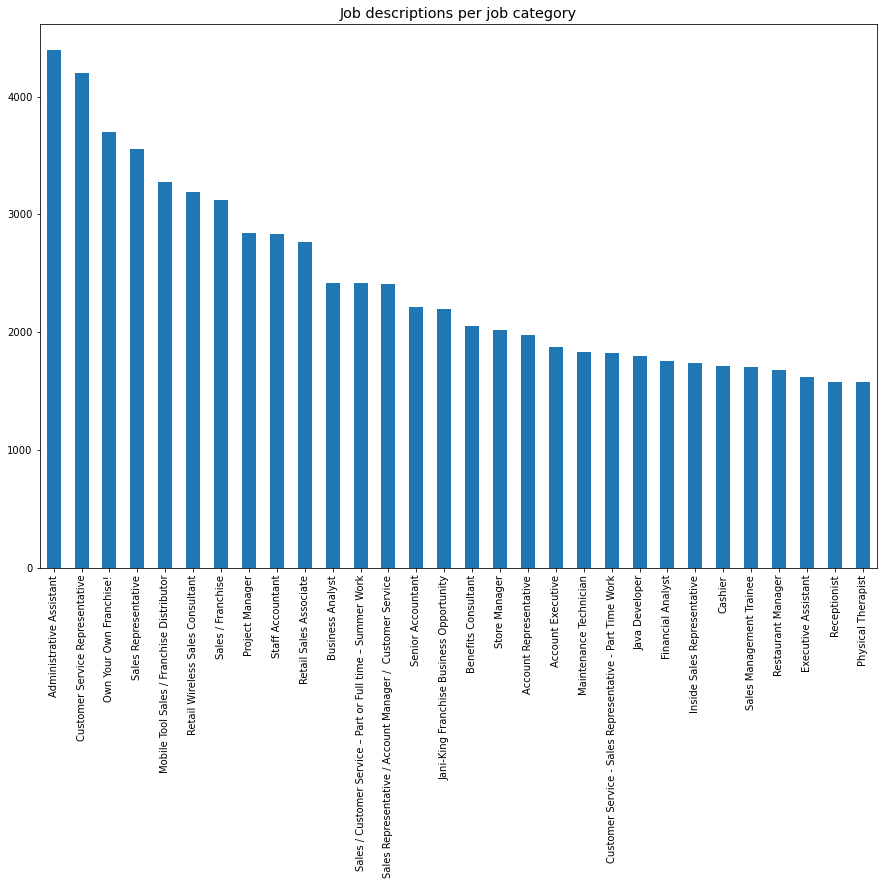

In [272]:
dataset_df['Query'].value_counts().plot(kind='bar')
plt.title('Job descriptions per job category')
plt.show()

In [5]:
dataset_df['Query'].value_counts()

Administrative Assistant                                      4395
Customer Service Representative                               4200
Own Your Own Franchise!                                       3701
Sales Representative                                          3556
Mobile Tool Sales / Franchise Distributor                     3275
Retail Wireless Sales Consultant                              3194
Sales / Franchise                                             3120
Project Manager                                               2845
Staff Accountant                                              2834
Retail Sales Associate                                        2769
Business Analyst                                              2420
Sales / Customer Service – Part or Full time – Summer Work    2419
Sales Representative / Account Manager /  Customer Service    2412
Senior Accountant                                             2216
Jani-King Franchise Business Opportunity                      

In [150]:
word_freq_dict = {}
for query in tqdm.tqdm(dataset_df['Query'].unique()):
    word_freq_dict[query] = get_top_n_words(dataset_df[dataset_df['Query']==query]['Description'], n=10, ngram_range=(1,4))

100%|██████████| 30/30 [04:44<00:00,  9.49s/it]


In [151]:
for query in word_freq_dict:
    stat_string = "\n".join([f"{word_freq[0]:35} {word_freq[1]:.2f}" for word_freq in word_freq_dict[query]])
    print(f'''
===
{query}

{stat_string}
    ''')


===
Administrative Assistant

administrative                      266.91
assistant                           206.03
office                              196.27
administrative assistant            189.15
work                                158.23
support                             153.19
skill                               149.77
position                            143.71
experience                          143.18
service                             141.68
    

===
Sales Representative

sale                                468.84
customer                            242.38
representative                      209.59
service                             200.72
avon                                186.32
sale representative                 184.95
opportunity                         183.49
business                            175.10
sell                                154.34
product                             153.43
    

===
Customer Service Representative

customer                          

# Preprocessing

Raw data

In [295]:
dataset_df['Description'][0]

'This Administrative Assistant position is responsible for performing a variety of clerical and administrative support functions in the areas of communications, data entry and retrieval, typing, filing, copying, and coordination of related administrative activities. \\r\\n\\r\\nJOB REQUIREMENTS:\\r\\nAttention to detail\\r\\nAbility to work in a fast paced environment\\r\\nInvoicing\\r\\nProficient in Word, Excel and Outlook\\r\\nOther Administrative responsibilities as needed.\\r\\n\\r\\nQUALIFICATIONS:\\r\\nHigh School Diploma\\r\\nAdministrative Assistant Experience\\r\\n1-2 Years work experience\\r\\nWorking knowledge of all basic office machines (fax, copier, 10key, etc.)\\r\\nStrong verbal and written communication skills\\r\\nStrong work ethic.'

Remove tags and stop words

In [296]:
SpacyTokenizer().tokenizer(dataset_df['Description'][0])

['administrative',
 'assistant',
 'position',
 'responsible',
 'perform',
 'variety',
 'clerical',
 'administrative',
 'support',
 'function',
 'area',
 'communication',
 'datum',
 'entry',
 'retrieval',
 'type',
 'file',
 'copy',
 'coordination',
 'relate',
 'administrative',
 'activity',
 'njob',
 'requirement',
 'nattention',
 'detail',
 'nability',
 'work',
 'fast',
 'pace',
 'environment',
 'ninvoicing',
 'nproficient',
 'word',
 'excel',
 'outlook',
 'nother',
 'administrative',
 'responsibility',
 'need',
 'nqualifications',
 'nhigh',
 'school',
 'diploma',
 'nadministrative',
 'assistant',
 'experience',
 'year',
 'work',
 'experience',
 'nworking',
 'knowledge',
 'basic',
 'office',
 'machine',
 'fax',
 'copier',
 'key',
 'etc',
 'nstrong',
 'verbal',
 'write',
 'communication',
 'skill',
 'nstrong',
 'work',
 'ethic']

# Classifier

In [ ]:
def split_train_test(dataset_df, y, test_size=0.2):
    # remove types occur only ones
    temp_df = dataset_df[y.isin(y.value_counts()[y.value_counts()>1].index)]
    return train_test_split(temp_df, stratify=y, test_size=test_size, random_state=42)

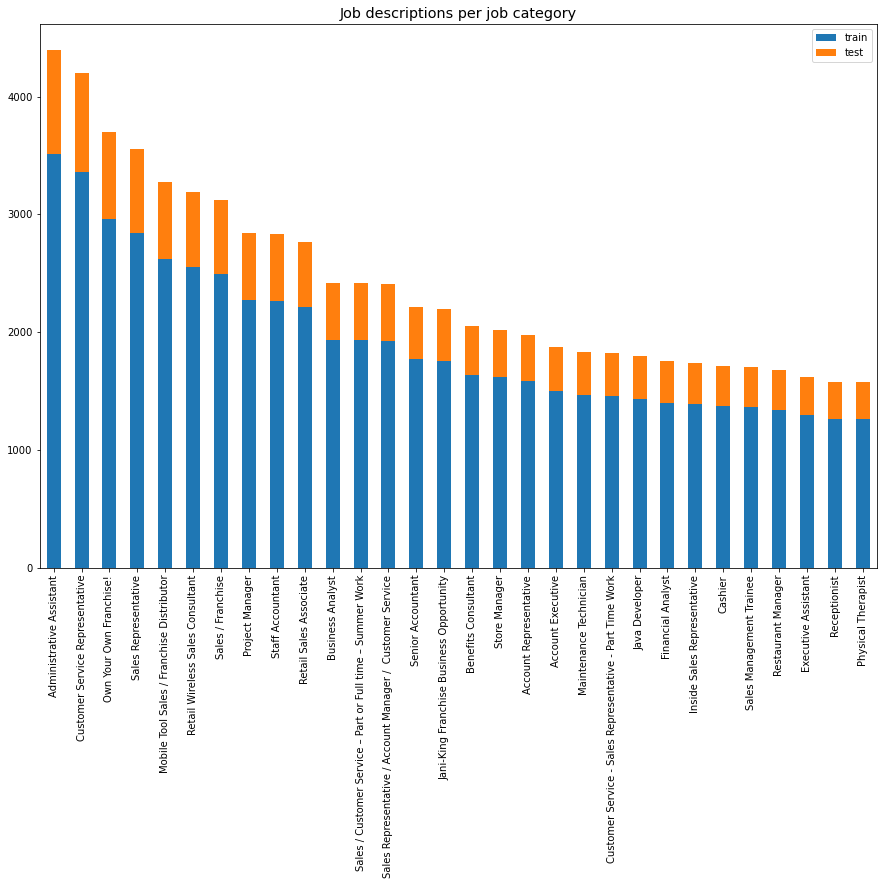

In [273]:
train, test = split_train_test(dataset_df, dataset_df['Query'], test_size=0.2)
split_df = pd.concat([train['Query'].value_counts(), test['Query'].value_counts()], axis=1)
split_df.columns = ['train', 'test']

split_df.plot(kind='bar', stacked=True)
plt.title('Job descriptions per job category')
plt.show()

In [180]:
print(f"train/test: {split_df['train'].sum()}/{split_df['test'].sum()}")
split_df

train/test: 57833/14459


,train,test
Administrative Assistant,3516,879
Customer Service Representative,3360,840
Own Your Own Franchise!,2961,740
Sales Representative,2845,711
Mobile Tool Sales / Franchise Distributor,2620,655
Retail Wireless Sales Consultant,2555,639
Sales / Franchise,2496,624
Project Manager,2276,569
Staff Accountant,2267,567
Retail Sales Associate,2215,554


## Naive Bayes classifier

In [239]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=SpacyTokenizer().tokenizer, max_features=2000)),
    ('clf', MultinomialNB(fit_prior=True, class_prior=None)),
])

parameters = {
    'tfidf__ngram_range': [(1, 2)],
    'clf__alpha': (1e-2, 1e-3)
}

nb_pipeline = tune_pipeline(pipeline, parameters, train['Description'], train['Query'], n_splits=5)
print(nb_pipeline.steps)
joblib.dump(nb_pipeline, './models/nb_pipeline.joblib')

pred = nb_pipeline.predict(test['Description'])
print(classification_report(test['Query'], pred))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  2.6min finished


[('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                tokenizer=<bound method SpacyTokenizer.tokenizer of <__main__.SpacyTokenizer object at 0x7f3fa111f9d0>>)), ('clf', MultinomialNB(alpha=0.001))]
                                                            precision    recall  f1-score   support

                                         Account Executive       0.79      0.79      0.79       375
                                    Account Representative       0.80      0.01      0.02       395
                                  Administrative Assistant       0.70      0.88      0.78       879
                                       Benefits Consultant       0.54      0.99      0.70       410
                                          Business Analyst       0.87      0.80      0.84       484
                                                   Cashier       0.96      0.87      0.91       343
  Customer Service - Sales Representative - Part Time Work       1.00    

## LogisticRegression

In [240]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=SpacyTokenizer().tokenizer, max_features=2000)),
    ('clf', LogisticRegression(solver='sag')),
])
parameters = {
    'tfidf__ngram_range': [(1, 2)],
    "clf__C": [0.01, 0.1, 1],
    "clf__class_weight": ['balanced', None],
}

logistic_regression_pipeline = tune_pipeline(pipeline, parameters, train['Description'], train['Query'], n_splits=5)
print(logistic_regression_pipeline.steps)
joblib.dump(logistic_regression_pipeline, './models/logistic_regression_pipeline.joblib')

pred = logistic_regression_pipeline.predict(test['Description'])
print(classification_report(test['Query'], pred))

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  6.5min
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:  8.1min finished


[('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                tokenizer=<bound method SpacyTokenizer.tokenizer of <__main__.SpacyTokenizer object at 0x7f3fba5d9910>>)), ('clf', LogisticRegression(C=1, class_weight='balanced', solver='sag'))]
                                                            precision    recall  f1-score   support

                                         Account Executive       0.90      0.92      0.91       375
                                    Account Representative       0.75      0.92      0.82       395
                                  Administrative Assistant       0.91      0.84      0.87       879
                                       Benefits Consultant       0.99      0.70      0.82       410
                                          Business Analyst       0.95      0.90      0.92       484
                                                   Cashier       0.98      0.96      0.97       343
  Customer Service - Sales Representa

## DecisionTreeClassifier

In [241]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=SpacyTokenizer().tokenizer, max_features=2000)),
    ('clf', DecisionTreeClassifier()),
])
parameters = {
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    "clf__class_weight": ['balanced', None],
}

decision_tree_pipeline = tune_pipeline(pipeline, parameters, train['Description'], train['Query'], n_splits=5)
print(decision_tree_pipeline.steps)
joblib.dump(decision_tree_pipeline, './models/decision_tree_pipeline.joblib')

pred = decision_tree_pipeline.predict(test['Description'])
print(classification_report(test['Query'], pred))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done   6 out of   8 | elapsed:  4.5min remaining:  1.5min
[Parallel(n_jobs=2)]: Done   8 out of   8 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   8 out of   8 | elapsed:  6.0min finished


[('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                tokenizer=<bound method SpacyTokenizer.tokenizer of <__main__.SpacyTokenizer object at 0x7f3faebf1350>>)), ('clf', DecisionTreeClassifier(class_weight='balanced'))]
                                                            precision    recall  f1-score   support

                                         Account Executive       0.94      0.89      0.91       375
                                    Account Representative       0.72      0.96      0.82       395
                                  Administrative Assistant       0.85      0.83      0.84       879
                                       Benefits Consultant       1.00      0.70      0.82       410
                                          Business Analyst       0.86      0.86      0.86       484
                                                   Cashier       0.95      0.96      0.95       343
  Customer Service - Sales Representative - Part Tim

## LinearSVC classifier

In [242]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=SpacyTokenizer().tokenizer, max_features=2000)),
    ('clf', LinearSVC(multi_class='ovr'))
])

parameters = {
    'tfidf__ngram_range': [(1, 2)],
    "clf__C": [0.01, 0.1, 1],
    "clf__class_weight": ['balanced', None],
}

linear_svc_pipeline = tune_pipeline(pipeline, parameters, train['Description'], train['Query'], n_splits=5)
print(linear_svc_pipeline.steps)
joblib.dump(linear_svc_pipeline, './models/linear_svc_pipeline.joblib')

pred = linear_svc_pipeline.predict(test['Description'])
print(classification_report(test['Query'], pred))

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:  7.5min finished


[('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                tokenizer=<bound method SpacyTokenizer.tokenizer of <__main__.SpacyTokenizer object at 0x7f3fc1b97c90>>)), ('clf', LinearSVC(C=1))]
                                                            precision    recall  f1-score   support

                                         Account Executive       0.93      0.91      0.92       375
                                    Account Representative       0.75      0.93      0.83       395
                                  Administrative Assistant       0.88      0.91      0.89       879
                                       Benefits Consultant       0.99      0.70      0.82       410
                                          Business Analyst       0.94      0.92      0.93       484
                                                   Cashier       0.98      0.96      0.97       343
  Customer Service - Sales Representative - Part Time Work       1.00      1.00      

# Test

In [274]:
classifier_pipeline = joblib.load('./models/linear_svc_pipeline.joblib')

In [292]:
test_record = test.sample().iloc[0]
print(f"Category: {test_record['Query']}")
print(f"Description: {test_record['Description']}")

Category: Restaurant Manager
Description: <P style="TEXT-ALIGN: center"><STRONG>Piccadilly Restaurant Management<BR>\rOpportunities!<BR>\r<BR>\r</STRONG>We are interviewing high energy Restaurant Manager Candidates for our locations throughout Richmond, VA.<BR>\r<BR>\r<STRONG>Join Us For Interviews<BR>\rTuesday, June 5th<BR>\r9:30am - 4:30pm<BR>\r@<BR>\rPiccadilly<BR>\r8004 Broad Street<BR>\rRichmond, VA<BR>\r<BR>\rFor consideration, please email or fax your resume to: <BR>\r</STRONG><A href="mailto:FTM@selfopportunity.com"><STRONG>FTM@selfopportunity.com</STRONG></A> <STRONG>or 469-671-3828<BR>\r</STRONG><BR>\rYou may also call 800-594-7036 Ext. 120 to schedule your interview.<BR>\r<BR>\r<STRONG>Management Candidates:<BR>\r</STRONG></P>\r<P>Must have drive and flexibility.  Must have 2-4 years supervisory or management in QSR, contract dining or fast casual concept.</P>\r<P><STRONG><BR>\rCompetitive Salaries and Benefits:<BR>\r</STRONG>*5-Day Work Week - 2 consecutive days off<BR>\r*E

In [293]:
classifier_pipeline.predict([test_record['Description']])

array(['Restaurant Manager'], dtype=object)